In [2]:
from spatial_interpolation import data, utils
from experiments.configs.evaluation import eval_sets

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from subplotted import subplotted
from pandas import IndexSlice as idx
eval_sets = eval_sets.ndbc

In [3]:
# get the data
ndbc_data = data.NDBCDataLoader(start="2011-01-01", end="2022-01-01").load()
df, ndbc_gdf = ndbc_data.buoys_data, ndbc_data.buoys_geo
df_countries = data.load_world_borders()
ndbc_data_7d = ndbc_data.join(resample="7D").dropna(subset=["geometry"])
ndbc_data_daily = ndbc_data.join(resample="D").dropna(subset=["geometry"])
ndbc_df = data.NDBCData(df, ndbc_gdf).join()

available_time = df.index.get_level_values("time").unique()
time_range = pd.date_range(available_time.min(), available_time.max(), freq="H")

In [4]:
# for deterministic and kriging experimetns
time_steps = (
    time_range
    .to_series(name="time_step")
    .rename_axis("time")
    .rank(ascending=True)
)
df_by_times = (
    ndbc_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=["wave_height"])
    .join(time_steps)
)

In [ ]:
## visualize each partial area (A, B, C)
# transform data
ndbc_geo = ndbc_gdf.loc[2000:2022].groupby("buoy_id").first()
ndbc_data_daily = ndbc_data_daily.dropna(subset=["wave_height"])
available_buoys = ndbc_data_daily.groupby("buoy_id").size()[ndbc_data_daily.groupby("buoy_id").size()>35].index
ndbc_geo = ndbc_geo[ndbc_geo.index.isin(available_buoys)]
eval_area = "set1"
eval_area_conf = eval_sets[eval_area]
partial_confs = eval_area_conf.partial.values()[::-1] if eval_area=="set1" else eval_area_conf.partial.values()
full_buoys = eval_area_conf.locations_full
num_cols = 3

# fig, axes = plt.subplots(len(eval_sets.ndbc), 1, figsize=(12,16))
for S, ax, (i, partial_conf) in subplotted(enumerate(partial_confs), ncols=num_cols, figsize=(4*(num_cols+2),16-5*(num_cols-1)), facecolor=None):
    partial_buoys = partial_conf.locations
    start, end = utils.parse_start_end(partial_conf.time.start, partial_conf.time.end)
    available_on_period = df.loc[idx[:,start:end],:].dropna(subset=["wave_height"]).index.get_level_values("buoy_id").value_counts()
    available_on_period = available_on_period.index
    set_geo =  ndbc_geo.loc[ndbc_geo.within(eval_area_conf.area)]
    set_geo = set_geo[set_geo.index.isin(available_on_period)]
    xmin, ymin, xmax, ymax = eval_area_conf.area.bounds
    df_countries.plot(ax=ax, alpha=0.5)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    set_geo.plot(ax=ax, color="blue")
    # red points represent buoys in the eval set
    set_geo[(set_geo.index.isin(partial_buoys)) ].plot(ax=ax, color="red", alpha=0.5)
    set_geo[(set_geo.index.isin(full_buoys))].plot(ax=ax, color="red")
    # those surrounded by a circle represent buoys that are fully in the eval set (not partial)
    set_geo[set_geo.index.isin(partial_buoys)].plot(ax=ax, marker="o", markersize=500, facecolor="none", edgecolor="red")
    if num_cols==1:
        ax.set_ylabel(f"Set {chr(ord('A')+i)}", rotation=0, fontsize=12, labelpad=25, fontweight="bold")
    else:
        ax.set_title(f"Set {chr(ord('A')+i)}", fontweight="bold")
    # bold xlabel
    ax.set_xlabel(f"Evaluated from {start:%b %d, %Y} to {end:%b %d, %Y}", fontsize=10, fontweight="bold")
    ax.set_xticks([]); ax.set_yticks([])
else:
    # S.fig.suptitle(f"Partial Evaluation sets of Area {eval_area[-1]}", fontsize=16)
    S.fig.tight_layout();
    # accomodate to give margin for the title
    S.fig.subplots_adjust(top=0.96);
    S.fig.savefig(f"reports/figures/ndbc_partial_{eval_area}.png", dpi=300, bbox_inches="tight")
S.fig.show()


In [ ]:
## visualize specific partial areas
# transform data
ndbc_geo = ndbc_gdf.loc[2000:2022].groupby("buoy_id").first()
ndbc_data_daily = ndbc_data_daily.dropna(subset=["wave_height"])
available_buoys = ndbc_data_daily.groupby("buoy_id").size()[ndbc_data_daily.groupby("buoy_id").size()>35].index
ndbc_geo = ndbc_geo[ndbc_geo.index.isin(available_buoys)]

num_cols = 1
partial_sets = ["set1.partial.a", "set1.partial.b", "set2.partial.d", "set3.partial.e", "set3.partial.f"]

# fig, axes = plt.subplots(len(eval_sets.ndbc), 1, figsize=(12,16))
for S, ax, (i, partial_set) in subplotted(enumerate(partial_sets), ncols=num_cols, figsize=(4*(num_cols+2),16-4*(num_cols-1)+4), facecolor=None):
    eval_area_conf = eval_sets[partial_set.split(".")[0]]
    full_buoys = eval_area_conf.locations_full
    partial_conf = eval_sets[partial_set]
    partial_buoys = partial_conf.locations
    start, end = utils.parse_start_end(partial_conf.time.start, partial_conf.time.end)
    available_on_period = df.loc[idx[:,start:end],:].dropna(subset=["wave_height"]).index.get_level_values("buoy_id").value_counts()
    available_on_period = available_on_period.index
    set_geo =  ndbc_geo.loc[ndbc_geo.within(eval_area_conf.area)]
    set_geo = set_geo[set_geo.index.isin(available_on_period)]
    xmin, ymin, xmax, ymax = eval_area_conf.area.bounds
    df_countries.plot(ax=ax, alpha=0.5)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    set_geo.plot(ax=ax, color="blue")
    # red points represent buoys in the eval set
    set_geo[(set_geo.index.isin(partial_buoys)) ].plot(ax=ax, color="red", alpha=0.5)
    set_geo[(set_geo.index.isin(full_buoys))].plot(ax=ax, color="red")
    # those surrounded by a circle represent buoys that are fully in the eval set (not partial)
    set_geo[set_geo.index.isin(partial_buoys)].plot(ax=ax, marker="o", markersize=500, facecolor="none", edgecolor="red")
    set_name, _, partial = partial_set.split(".")
    ax.set_ylabel(f"Set {partial.upper()}\n(Area {set_name[-1].upper()})", rotation=0, fontsize=12, labelpad=30, fontweight="bold")
    # bold xlabel
    ax.set_xlabel(f"Evaluated from {start:%b %d, %Y} to {end:%b %d, %Y}", fontsize=10, fontweight="bold")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_anchor('E')
else:
    # S.fig.suptitle(f"Partial Evaluation sets of Area {eval_area[-1]}", fontsize=16)
    S.fig.tight_layout();
    # accomodate to give margin for the title
    S.fig.subplots_adjust(top=0.96);
    S.fig.savefig(f"reports/figures/ndbc_partial_various.png", dpi=300, bbox_inches="tight")
S.fig.show()


### Visualize interpolations

In [7]:
from spatial_interpolation.interpolators import *
from experiments.noaa import NOAADeterministicExperiment, NOAAKrigingExperiment, NOAAMLTraining
from spatial_interpolation.visualization import plot_interpolation, map_viz
import re

In [182]:
exp = NOAADeterministicExperiment
configs = ["linear_interpolation", "idw_interpolation", "rbf_interpolation"]
interpolator_cls = ScipyInterpolator
interpolator_name_from_config = lambda conf: f"{conf.split('_')[0].capitalize()}"


# exp = NOAAKrigingExperiment
# configs = ["ok_gaussian_set1", "ok_spherical_set2", "ok_matern_set3"]
# interpolator_cls = None
# interpolator_name_from_config = lambda conf: f"Ordinary Kriging (" + re.sub("ok_(.*)_.*", "\\1", conf).capitalize() + ")"

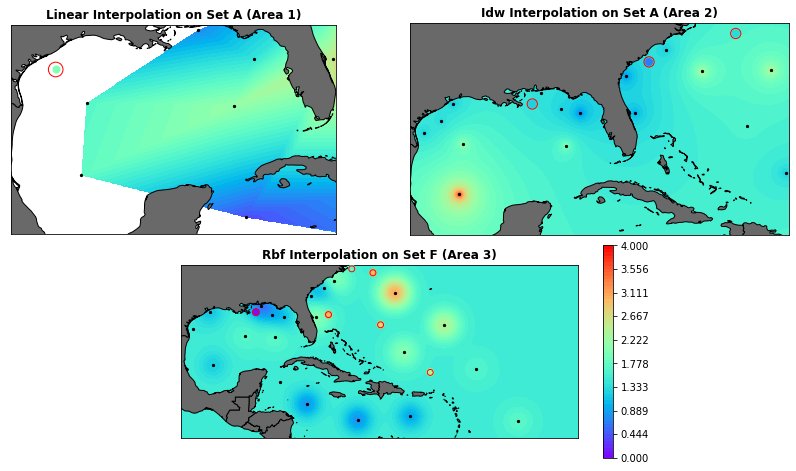

In [183]:
## interpolate and visualize specific partial areas

target = "wave_height"
num_cols = 3
partial_sets = ["set1.partial.a", "set2.partial.a", "set3.partial.f"]
fig_mosaic = """
    AABBB
    AABBB
    .CCC.
    .CCC.
"""
fig = plt.figure(constrained_layout=False, figsize=(15,8), facecolor=None)
axd = fig.subplot_mosaic(fig_mosaic, gridspec_kw=dict(hspace=0.1, wspace=0.1))
CS = None
vmin, vmax = 0,4 #df_by_times[target].min(), df_by_times[target].max()
# fig, axes = plt.subplots(len(eval_sets.ndbc), 1, figsize=(12,16))
for ax, partial_set, conf in zip(axd.values(),partial_sets, configs):
    config = exp(conf).get_config()
    interpolator_params = dict(dimensions=config.dimensions,**config.interpolator_params)
    interpolator_params["interpolator"] = config.interpolator
    interpolator = interpolator_cls(**interpolator_params) if interpolator_cls is not None else config.interpolator(**interpolator_params)
    eval_area_conf = eval_sets[partial_set.split(".")[0]]
    full_buoys = eval_area_conf.locations_full
    partial_conf = eval_sets[partial_set]
    partial_buoys = partial_conf.locations
    start, end = utils.parse_start_end(partial_conf.time.start, partial_conf.time.end)
    available_on_time = df_by_times.loc[start:end,:].dropna(subset=["wave_height"]).index.get_level_values("location_id").unique()
    mid_point = df_by_times.loc[start:end,:].index.get_level_values("time").to_series().median()
    df_train = df_by_times.loc[idx[[mid_point],available_on_time[~available_on_time.isin(partial_buoys+full_buoys)]],: ]
    df_test = df_by_times.loc[idx[[mid_point],available_on_time[available_on_time.isin(partial_buoys+full_buoys)]],: ]
    
    interpolator.fit(df_train.loc[mid_point],y=target)
    # print(min(df_train[target].min(), df_test[target].min()), max(df_train[target].max(), df_test[target].max()))

    ax, CS = plot_interpolation(
        df_train.loc[mid_point,"longitude"],df_train.loc[mid_point,"latitude"],
        df_test.loc[mid_point,"longitude"],df_test.loc[mid_point, "latitude"],
        df_test.loc[mid_point][target],
        interpolator,
        bbox=eval_area_conf.area.bounds,
        radius=.4,
        ax=ax,
        num_points=300,
        title="",
        latlon=False,
        dim_cols=interpolator.dim_cols,
        colorbar=False,
        map_args=dict(color="dimgray", alpha=1, edgecolor="black"),
        cmap=CS.cmap if CS is not None else "rainbow",
        levels=np.linspace(vmin, vmax, 64),
    )
    ax.set_title(f"{interpolator_name_from_config(conf)} Interpolation on Set {partial_set.split('.')[-1].upper()} (Area {partial_set.split('.')[0][-1].upper()})", fontweight="bold")
    ax.set(xlabel="", ylabel="")
    ax.set_xticks([]); ax.set_yticks([])
    # ax.set_anchor('E')
else:
    # S.fig.suptitle(f"Partial Evaluation sets of Area {eval_area[-1]}", fontsize=16)
    # accomodate to give margin for the title
    # fig.subplots_adjust(top=0.96);
    fig.colorbar(CS)
    exp_type = re.sub("NOAA(.*)Experiment", "\\1", exp.__name__).lower()
    fig.savefig(f"reports/figures/{exp_type}_interpolations_various.png", dpi=300, bbox_inches="tight")
fig.tight_layout();
# CS.set_array(df_by_times[target].iloc[:100])

fig.show()


### ML 

In [5]:
from spatial_interpolation.pipelines.feature_interpolation import feature_extraction
import mlflow
from spatial_interpolation.utils.modeling import tweak_features

logged_model = 'runs:/4322b34fb81a407a962eb39fd34a4225/lgbmregressor'

# Load model as a PyFuncModel.
lgb_model = mlflow.pyfunc.load_model(logged_model)
partial_preds = {}

In [ ]:
exp = NOAAMLTraining

conf = "lgbm_config"
config = exp(conf).get_config()
fe_pipe = feature_extraction.NDBCFeatureExtractor(**config.feature_extraction)
partial_sets = ["set1.partial.a", "set2.partial.a", "set3.partial.f"]


fig_mosaic = """
    AABBB
    AABBB
    .CCC.
    .CCC.
"""
fig = plt.figure(constrained_layout=False, figsize=(15,11), facecolor=None)
axd = fig.subplot_mosaic(fig_mosaic, gridspec_kw=dict(hspace=0.1, wspace=0.1))
CS = None
vmin, vmax = 0,4 #df_by_times[target].min(), df_by_times[target].max()

for ax, partial in zip(axd.values(),partial_sets):
    eval_area_conf = eval_sets[partial.split(".")[0]]
    partial_conf = eval_sets.get(partial)
    start, end = utils.parse_start_end(partial_conf.time.start, partial_conf.time.end)
    mid_point = df_by_times.loc[start:end,:].index.get_level_values("time").to_series().median()
    delta = pd.Timedelta(7, "h")

    full_buoys = eval_area_conf.locations_full
    partial_buoys = partial_conf.locations

    available_on_time = df_by_times.loc[start:end,:].dropna(subset=["wave_height"]).index.get_level_values("location_id").unique()
    df_test = df_by_times.loc[idx[[mid_point],available_on_time[available_on_time.isin(partial_buoys+full_buoys)]],: ]

    grid_resolution = config.get("grid", {}).get("resolution", 0.5)
    x_min, y_min, x_max, y_max = eval_area_conf.area.bounds
    X, Y = np.meshgrid(np.arange(x_min,x_max,grid_resolution),np.arange(y_min,y_max,grid_resolution))
    points = zip(X.ravel(),Y.ravel())
    points_gdf = feature_extraction.NDBCFeatureExtractor.make_points_from_grid(points)
    points_gdf.index.name = "location_id"
    points_gdf = pd.concat([
        points_gdf.copy().assign(time=t).set_index("time", append=True)
        for t in pd.date_range(mid_point-delta, mid_point, freq="H")
    ],axis=0).sort_index()
    points_gdf.loc[idx[:,mid_point],:]

    if partial in partial_preds:
        preds_gdf = partial_preds[partial]
    else:
        fe_pipe.fit(df.loc[idx[:,(mid_point-delta):mid_point],:], ndbc_gdf.loc[[mid_point.year]])
        points_features = fe_pipe.transform(points_gdf)
        X_pred = tweak_features(
            config.pretrain_funcs,
            points_features
        )[0]
        preds = lgb_model.predict(X_pred.loc[idx[:,mid_point],:])
        preds = pd.Series(preds, index=X_pred.loc[idx[:,mid_point],:].index, name="wave_height_pred")
        preds_gdf = points_gdf.loc[idx[:,mid_point],:].join(preds)
        partial_preds[partial] = preds_gdf

    z = preds_gdf.wave_height_pred
    Z = z.values.reshape(X.shape)
    borders_gdf = data.load_world_borders(boundaries=eval_area_conf.area.bounds)
    ax = borders_gdf.plot(color="dimgray", alpha=1, edgecolor="black", ax=ax, zorder=1)
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    CS = ax.contourf(X,Y,Z, cmap="rainbow", levels=np.linspace(0,4,64), zorder=0)
    x_test,y_test = df_test.loc[mid_point].longitude,df_test.loc[mid_point].latitude
    ax.scatter(x_test,y_test,c=df_test.loc[mid_point,"wave_height"],marker="o",s=50,zorder=10,cmap=CS.cmap, vmin=0, vmax=4)
    for i,(x,y) in enumerate(zip(x_test,y_test)):
        cir = plt.Circle((x,y),radius=0.4,color="red",zorder=10, fill=False)
        ax.add_artist(cir)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"Gradient Boosting Regressor Interpolation on Set {partial.split('.')[-1].upper()} (Area {partial.split('.')[0][-1].upper()})", fontweight="bold")

fig.tight_layout()
fig.savefig(f"reports/figures/lgbm_interpolations_various.png", dpi=300, bbox_inches="tight")
fig.colorbar(CS)

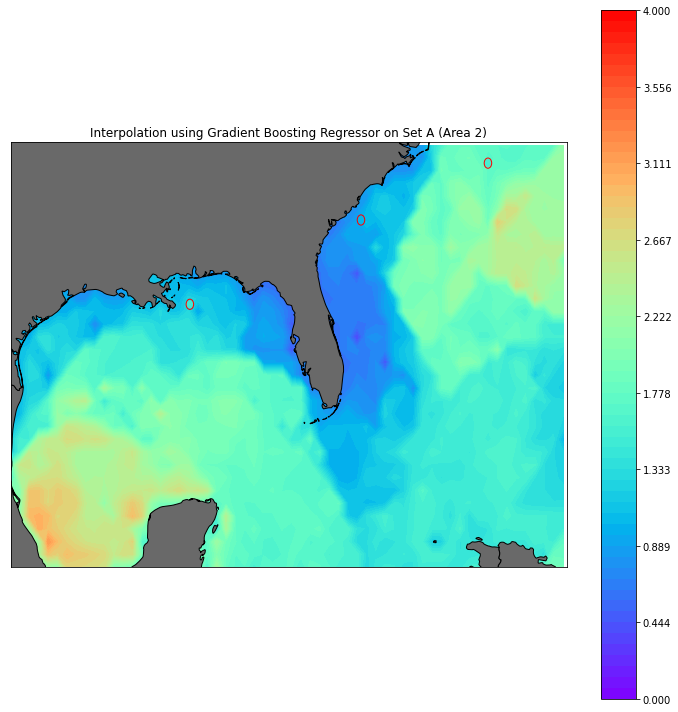

In [153]:
# preds_gdf = points_gdf.loc[idx[:,mid_point],:].join(preds)
z = preds_gdf.wave_height_pred
Z = z.values.reshape(X.shape)
borders_gdf = data.load_world_borders(boundaries=eval_area_conf.area.bounds)
fig, ax = plt.subplots(1,1,figsize=(10,10), facecolor=None)
ax = borders_gdf.plot(color="dimgray", alpha=1, edgecolor="black", ax=ax, zorder=1)
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
CS = ax.contourf(X,Y,Z, cmap="rainbow", levels=np.linspace(0,4,64), zorder=0)
fig.colorbar(CS)
ax.set(title=f"Interpolation using Gradient Boosting Regressor on Set {partial[-1].upper()} (Area 2)", xlabel="", ylabel="")
x_test,y_test = df_test.loc[mid_point].longitude,df_test.loc[mid_point].latitude
ax.scatter(x_test,y_test,c=df_test.loc[mid_point,"wave_height"],marker="o",s=50,zorder=10,cmap=CS.cmap, vmin=0, vmax=4)
for i,(x,y) in enumerate(zip(x_test,y_test)):
        cir = plt.Circle((x,y),radius=0.2,color="red",zorder=10, fill=False)
        ax.add_artist(cir)

ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
exp_type = re.sub("NOAA(.*).*", "\\1", exp.__name__).lower()
fig.savefig(f"reports/figures/{exp_type}_interpolations_various_partial.png", dpi=300, bbox_inches="tight")


### RK

In [14]:
exp = NOAAMLTraining

conf = "lgbm_config_set2"
config = exp(conf).get_config()
fe_pipe = feature_extraction.NDBCFeatureExtractor(**config.feature_extraction)
partial_sets = ["set1.partial.a", "set2.partial.a", "set3.partial.f"]

train_df = pd.concat(
    [pd.read_parquet(f"{config.input.train_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()
test_df = pd.concat(
    [pd.read_parquet(f"{config.input.eval_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()

# Make the X and Y train and test sets that will be passed to the model
X_train = train_df.drop(columns=[config.target]).copy()
y_train = train_df[config.target]
X_eval = test_df.drop(columns=[config.target]).copy()
y_eval = test_df[config.target]

X_train, X_eval = tweak_features(
    config.pretrain_funcs,
    X_train, X_eval
)
y_train = y_train.loc[X_train.index]
y_eval = y_eval.loc[X_eval.index]

In [22]:
exp = NOAAKrigingExperiment("ok_spherical_set2")
krige_config = exp.get_config()
krige = krige_config.interpolator(dimensions=krige_config.dimensions,**krige_config.interpolator_params)

In [ ]:

fig_mosaic = """
    AABBB
    AABBB
    .CCC.
    .CCC.
"""
fig = plt.figure(constrained_layout=False, figsize=(15,11), facecolor=None)
axd = fig.subplot_mosaic(fig_mosaic, gridspec_kw=dict(hspace=0.1, wspace=0.1))
CS = None
vmin, vmax = 0,4 #df_by_times[target].min(), df_by_times[target].max()

for ax, partial in zip(axd.values(),partial_sets):
    eval_area_conf = eval_sets[partial.split(".")[0]]
    partial_conf = eval_sets.get(partial)
    start, end = utils.parse_start_end(partial_conf.time.start, partial_conf.time.end)
    mid_point = df_by_times.loc[start:end,:].index.get_level_values("time").to_series().median()
    delta = pd.Timedelta(7, "h")

    full_buoys = eval_area_conf.locations_full
    partial_buoys = partial_conf.locations

    available_on_time = df_by_times.loc[start:end,:].dropna(subset=["wave_height"]).index.get_level_values("location_id").unique()
    df_test = X_train.join(train_df[["x","y", "wave_height"]]).loc[idx[available_on_time[available_on_time.isin(partial_buoys+full_buoys)], (mid_point-delta):mid_point],:]
    df_train = X_train.join(train_df[["x","y", "wave_height"]]).loc[idx[available_on_time[~available_on_time.isin(partial_buoys+full_buoys)], (mid_point-delta):mid_point],:]

    grid_resolution = config.get("grid", {}).get("resolution", 0.5)
    x_min, y_min, x_max, y_max = eval_area_conf.area.bounds
    X, Y = np.meshgrid(np.arange(x_min,x_max,grid_resolution),np.arange(y_min,y_max,grid_resolution))
    points = zip(X.ravel(),Y.ravel())
    points_gdf = feature_extraction.NDBCFeatureExtractor.make_points_from_grid(points)
    points_gdf.index.name = "location_id"
    points_gdf = pd.concat([
        points_gdf.copy().assign(time=t).set_index("time", append=True)
        for t in pd.date_range(mid_point-delta, mid_point, freq="H")
    ],axis=0).sort_index()
    points_gdf.loc[idx[:,mid_point],:]

    if partial in partial_preds:
        preds_gdf = partial_preds[partial]
    else:
        fe_pipe.fit(df.loc[idx[:,(mid_point-delta):mid_point],:], ndbc_gdf.loc[[mid_point.year]])
        points_features = fe_pipe.transform(points_gdf)
        X_pred = tweak_features(
            config.pretrain_funcs,
            points_features
        )[0]
        preds = lgb_model.predict(X_pred.loc[idx[:,mid_point],:])
        preds = pd.Series(preds, index=X_pred.loc[idx[:,mid_point],:].index, name="wave_height_pred")
        preds_gdf = points_gdf.loc[idx[:,mid_point],:].join(preds)
        partial_preds[partial] = preds_gdf
    
    train_preds = lgb_model.predict(X_train.loc[idx[:,mid_point],:])
    residuals = train_preds - y_train.loc[idx[:,mid_point]]
    krige.fit(X_train.join(train_df[["x","y"]]).rename(columns={"x":"longitude","y":"latitude"}).loc[idx[:,mid_point],:], residuals)

    krige_pred = krige.predict(
        points_gdf.loc[idx[:,mid_point],:].assign(
            latitude=points_gdf.geometry.apply(lambda x: x.y),
            longitude=points_gdf.geometry.apply(lambda x: x.x)
        )
    )
    krige_pred = pd.Series(krige_pred, index=points_gdf.loc[idx[:,mid_point],:].index, name="wave_height_pred")
    rk_preds = preds_gdf.wave_height_pred + krige_pred
    preds_gdf = points_gdf.loc[idx[:,mid_point],:].join(rk_preds)
    
    z = preds_gdf.wave_height_pred
    Z = z.values.reshape(X.shape)
    borders_gdf = data.load_world_borders(boundaries=eval_area_conf.area.bounds)
    ax = borders_gdf.plot(color="dimgray", alpha=1, edgecolor="black", ax=ax, zorder=1)
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    CS = ax.contourf(X,Y,Z, cmap="rainbow", levels=np.linspace(0,4,64), zorder=0)
    x_tst, y_tst = df_test.loc[idx[:,mid_point],:].x,df_test.loc[idx[:,mid_point],:].y
    x_tr,y_tr = df_train.loc[idx[:,mid_point],:].x,df_train.loc[idx[:,mid_point],:].y
    ax.scatter(x_tst,y_tst,c=df_test.loc[idx[:,mid_point],"wave_height"],marker="o",s=50,zorder=10,cmap=CS.cmap, vmin=0, vmax=4)
    ax.scatter(x_tr,y_tr,c=df_train.loc[idx[:,mid_point],"wave_height"],marker="o",s=100,zorder=10,cmap=CS.cmap, vmin=0, vmax=4)
    for i,(x,y) in enumerate(zip(x_tst,y_tst)):
        cir = plt.Circle((x,y),radius=0.4,color="red",zorder=10, fill=False)
        ax.add_artist(cir)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"Regression Kriging Interpolation on Set {partial.split('.')[-1].upper()} (Area {partial.split('.')[0][-1].upper()})", fontweight="bold")

fig.tight_layout()
# fig.savefig(f"reports/figures/lgbm_interpolations_various.png", dpi=300, bbox_inches="tight")
fig.colorbar(CS)